## Part 3 -  Logistic Regression Classifier

In this jupyter notebook I will be feeding the data that are coming from Part 2 into a logistic regression classifier, to predict whether a post is coming either from the sustainability or climate change subreddit. More precisely, there will be two different logistic regression models:i) the first model is using only the words that are coming from the title_selftext column; ii) the second one instead will be adding the sentiment score. The goal is to see if the sentiment detected in the different texts can improve to the accuracy score of the classifier model

### Section 1 - Library and Data Import

In [262]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,  cross_val_score, RandomizedSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import FunctionTransformer
import pprint as pp

from sklearn.pipeline import FeatureUnion
import sklearn.metrics as metrics



In [263]:
df = pd.read_csv('../data/reddits_cleaned_sentiment.csv')

In [264]:
#checking first 2 rows
df.head(2) 

,subreddit,title_selftext,sentiment_score
0,1,why does many big crop starting to have sustai...,0.0
1,1,use new phone for 5 years or refurbished phone...,0.0


In [265]:
#looking at the info of the df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7999 entries, 0 to 7998
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   subreddit        7999 non-null   int64  
 1   title_selftext   7999 non-null   object 
 2   sentiment_score  7999 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 187.6+ KB


### Section 2 - Logistic Regression Classifier

There are only two different things that I will be using in both model and that I want to include in this section:i)the null model; ii) a common stop_words hyperparameter

In [266]:
#The Null Model
null_model = df['subreddit'].value_counts(normalize=True)
#Baseline Accuracy: ~50% (class 1)
null_model

1    0.500438
0    0.499562
Name: subreddit, dtype: float64

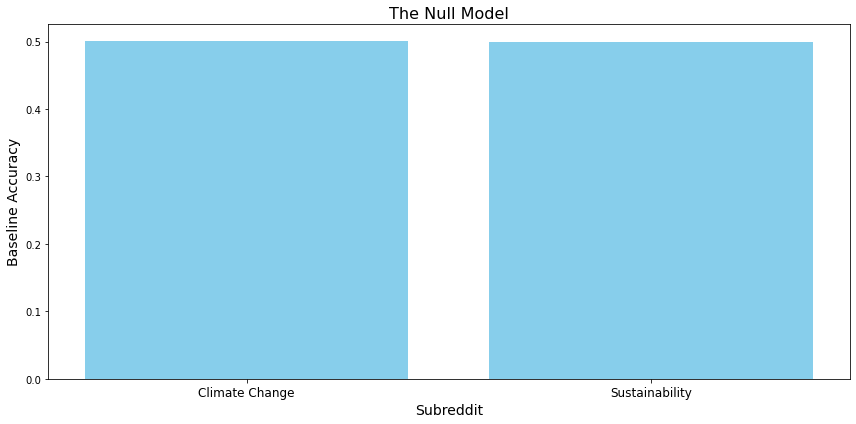

In [267]:
plt.figure(figsize=(12,6))
x = range(len(null_model.reset_index()))
y = null_model.reset_index().loc[:,'subreddit']
plt.bar(x,y, color='skyblue')
ax = plt.subplot()
ax.set_xticks(x)
ax.set_xticklabels(['Climate Change', 'Sustainability'], fontdict= {'fontsize':12})
ax.set_xlabel('Subreddit', fontdict= {'fontsize':14})
ax.set_ylabel('Baseline Accuracy', fontdict= {'fontsize':14})
ax.set_title('The Null Model', fontdict = {'fontsize':16})
plt.tight_layout();

In [268]:
#Here I am creating a new stop_words vocabulary for both models
cvec = CountVectorizer(stop_words='english')
stop_words = list(cvec.get_stop_words())
lst = ['help','com' ,'have','ve' ,"does", 'know', "don", 'want', 'website', 'row', 'let', 'hey', 'guys', 
       'like', 'hey', 'place', 'http', 'www', 'bytes', 'think', "don't", "doesn't", "does", 'just', 
       'people', 'use',"i've", 'hi', 'need', 'doesn']

stop_words = stop_words + lst

### Section 2.1 - Logistic Regression without Sentiment Analysis

**Step 1** Assembling Predictors, Target and train_test_split

In [269]:
X = df['title_selftext']
y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)

**Step 2** Instantiate and fitting The Pipeline  

In [270]:
# Instantiate a pipeline
pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('lr', LogisticRegression(max_iter=1000))
])
#fitting the pipe
pipe.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()),
                ('lr', LogisticRegression(max_iter=1000))])

In [271]:
#Checking at my train, test, cross val score
pipe.score(X_train,y_train), pipe.score(X_test,y_test), cross_val_score(pipe,X_train,y_train ).mean()

(0.966494415735956, 0.8065, 0.8099681679177092)

**Step 3** Instantiate and Fitting RandomizedSearchCV

In [272]:
#First off, I want to define the parameters for the models established within the pipeline 
params = {
    'vect__stop_words':[stop_words],
    'vect__min_df': list(range(1,10)),
    'vect__max_df': [1.0, .75, .5, 0.25],
    'vect__binary': [True, False],
    'vect__ngram_range': [(2, 2), (1,1), (1,2)], 
    'vect__max_features': [500, 1_000, 2_000], 
    'lr__C':[0.05, 0.1, 0.5,1]
    
}
#Instantiating GridSearch with pipe and parameters established before
#setting up a random state to ensure replicability of results
rs = RandomizedSearchCV(pipe, params, cv=5, verbose = 1, n_iter=10, scoring='accuracy',random_state=430)
#Fitting the GridSearch
rs.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                             ('lr',
                                              LogisticRegression(max_iter=1000))]),
                   param_distributions={'lr__C': [0.05, 0.1, 0.5, 1],
                                        'vect__binary': [True, False],
                                        'vect__max_df': [1.0, 0.75, 0.5, 0.25],
                                        'vect__max_features': [500, 1000, 2000],
                                        'vect__min_df': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9],
                                        'vect__ngram_range': [(2, 2), (1, 1),
                                                              (1, 2)],
                                        'vect__stop_words': [['made', 'each',
                                                              'are', 'over',
                 

In [273]:
#Taking a look at cross val score
rs.best_score_

0.8129673338893522

In [274]:
#Taking a look at best parameters
rs.best_params_

{'vect__stop_words': ['made',
  'each',
  'are',
  'over',
  'elsewhere',
  'nothing',
  'whereby',
  'its',
  'together',
  'whither',
  'among',
  'part',
  'toward',
  'already',
  'less',
  'whether',
  'am',
  'seem',
  'then',
  'therefore',
  'couldnt',
  'onto',
  'who',
  'when',
  'everywhere',
  'while',
  'interest',
  'such',
  'show',
  'eg',
  'will',
  'next',
  'many',
  'whose',
  'hereupon',
  'found',
  'but',
  'beside',
  'perhaps',
  'whereas',
  'so',
  'upon',
  'became',
  'after',
  'call',
  'hereby',
  'six',
  'thus',
  'ever',
  'throughout',
  'seeming',
  'through',
  'for',
  'have',
  'down',
  'least',
  'an',
  'thru',
  'most',
  'our',
  'be',
  'into',
  'etc',
  'several',
  'above',
  'below',
  'find',
  'myself',
  'co',
  'whereafter',
  'it',
  'under',
  'a',
  'this',
  'indeed',
  'more',
  'beyond',
  'or',
  'must',
  'me',
  'back',
  'across',
  'themselves',
  'sincere',
  'own',
  'except',
  'well',
  'wherever',
  'he',
  'at',
 

**Step 4** Model Evaluation

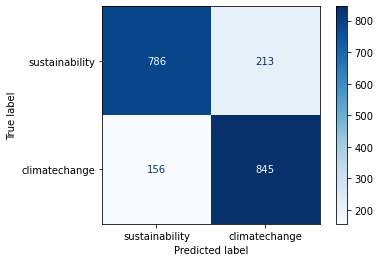

In [275]:
# I want to first take a look at my confusion matrix
plot_confusion_matrix(rs, X_test, y_test, display_labels=['sustainability', 'climatechange'], 
                      cmap='Blues')

In [276]:
#looking at the predictions
preds = rs.predict(X_test)
#identifying values of my confusion matrix 
tn, fp, fn, tp = metrics.confusion_matrix(y_test, preds).ravel()
# calculating sensitivity, specificity and overall accuracy
sensitivity_1 = tp/(tp+fn)
specificity_1 = tn/(tn+fp)
accuracy_1 = (tp+tn)/(tp+tn+fn+fp)
precision_1 = (tp)/(tp+fp)
#printing results
sensitivity_1, specificity_1, accuracy_1, precision_1

(0.8441558441558441, 0.7867867867867868, 0.8155, 0.7986767485822306)

In [277]:
#calculating ROC AUC Score
probs = rs.predict_proba(X_test)[:,1]
metrics.roc_auc_score(y_test, probs)

0.9057464057464057

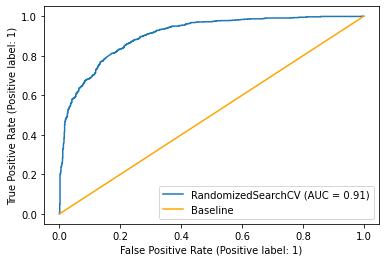

In [278]:
# Source: this graph is coming from class classification metrics II
# I want to visualize teh false positive rate against the true positive rate
metrics.plot_roc_curve(rs, X_test, y_test)
plt.plot([0,1], [0,1], color ='orange', label ='Baseline')
plt.legend()

/Users/filoradice/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


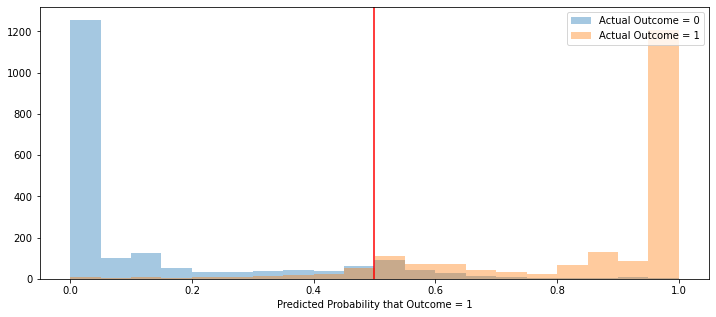

In [279]:
# Source: this graph is coming from class classification metrics II

df_probs = pd.DataFrame({'true_values': y_test, 'preds_prob':probs})
plt.figure(figsize = (12, 5))

# plot distributions of predicted probabilities by actual values
for group in df_probs.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')
# Add cutoff line
plt.axvline(.5, color='r')

plt.xlabel('Predicted Probability that Outcome = 1')
plt.legend();

### Section 2.2 - Logistic Regression with Sentiment Analysis

**Step 1** Assembling Predictors, Target and train_test_split

In [280]:
X = df.drop(columns=['subreddit'])
y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)


**Step 2** Transforming predictors; instantiating two  separate Pipelines 

In [281]:
# all functions below and everything related to feature union comes from Professor Riley Dallas

In [282]:
def get_title(df):
    return df['title_selftext']
get_title_transformer = FunctionTransformer(get_title, validate=False)

def get_other_col(df):
    return df[['sentiment_score']]
get_col_transformer = FunctionTransformer(get_other_col, validate=False)

In [283]:
pipe_cv = Pipeline([
    ('title_transform', get_title_transformer),
    ('vect', CountVectorizer())
])


In [284]:
pipe_model = Pipeline([
    ('feats', FeatureUnion([
        ('vect_pipe', pipe_cv),
        ('other_cols', get_col_transformer)
    ])),
    ('lr', LogisticRegression(max_iter=1000))
])

**Step 3** Instantiate and Fitting RandomizedSearchCV

In [285]:
#checking at how should I call pipes's parameters
pp.pprint(sorted(pipe_model.get_params().keys()))

['feats',
 'feats__n_jobs',
 'feats__other_cols',
 'feats__other_cols__accept_sparse',
 'feats__other_cols__check_inverse',
 'feats__other_cols__func',
 'feats__other_cols__inv_kw_args',
 'feats__other_cols__inverse_func',
 'feats__other_cols__kw_args',
 'feats__other_cols__validate',
 'feats__transformer_list',
 'feats__transformer_weights',
 'feats__vect_pipe',
 'feats__vect_pipe__memory',
 'feats__vect_pipe__steps',
 'feats__vect_pipe__title_transform',
 'feats__vect_pipe__title_transform__accept_sparse',
 'feats__vect_pipe__title_transform__check_inverse',
 'feats__vect_pipe__title_transform__func',
 'feats__vect_pipe__title_transform__inv_kw_args',
 'feats__vect_pipe__title_transform__inverse_func',
 'feats__vect_pipe__title_transform__kw_args',
 'feats__vect_pipe__title_transform__validate',
 'feats__vect_pipe__vect',
 'feats__vect_pipe__vect__analyzer',
 'feats__vect_pipe__vect__binary',
 'feats__vect_pipe__vect__decode_error',
 'feats__vect_pipe__vect__dtype',
 'feats__vect_pip

In [286]:
#Here I am proposing the same parameters I selected for my first model
params_2 = {
    'feats__vect_pipe__vect__stop_words':[stop_words],
    'feats__vect_pipe__vect__min_df': list(range(1,10)),
    'feats__vect_pipe__vect__max_df': [1.0, .75, .5, 0.25],
    'feats__vect_pipe__vect__binary': [True, False],
    'feats__vect_pipe__vect__ngram_range': [(2, 2), (1,1), (1,2)], 
    'feats__vect_pipe__vect__max_features': [500, 1_000, 2_000], 
    'lr__C':[0.05, 0.1, 0.5,1]}

rs_2 = RandomizedSearchCV(pipe_model, params_2, scoring='accuracy',n_iter=10, random_state=430)
rs_2.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('feats',
                                              FeatureUnion(transformer_list=[('vect_pipe',
                                                                              Pipeline(steps=[('title_transform',
                                                                                               FunctionTransformer(func=<function get_title at 0x7f9f75fcc5e0>)),
                                                                                              ('vect',
                                                                                               CountVectorizer())])),
                                                                             ('other_cols',
                                                                              FunctionTransformer(func=<function get_other_col at 0x7f9f75fcc670>))])),
                                             ('lr',
                                              LogisticRegress

In [287]:
print(rs_2.best_score_)
print(rs_2.best_params_)

0.820635807617459
{'lr__C': 0.1, 'feats__vect_pipe__vect__stop_words': ['made', 'each', 'are', 'over', 'elsewhere', 'nothing', 'whereby', 'its', 'together', 'whither', 'among', 'part', 'toward', 'already', 'less', 'whether', 'am', 'seem', 'then', 'therefore', 'couldnt', 'onto', 'who', 'when', 'everywhere', 'while', 'interest', 'such', 'show', 'eg', 'will', 'next', 'many', 'whose', 'hereupon', 'found', 'but', 'beside', 'perhaps', 'whereas', 'so', 'upon', 'became', 'after', 'call', 'hereby', 'six', 'thus', 'ever', 'throughout', 'seeming', 'through', 'for', 'have', 'down', 'least', 'an', 'thru', 'most', 'our', 'be', 'into', 'etc', 'several', 'above', 'below', 'find', 'myself', 'co', 'whereafter', 'it', 'under', 'a', 'this', 'indeed', 'more', 'beyond', 'or', 'must', 'me', 'back', 'across', 'themselves', 'sincere', 'own', 'except', 'well', 'wherever', 'he', 'at', 'top', 'now', 'nine', 'thick', 'once', 'give', 'un', 'never', 'first', 'their', 'fifteen', 'often', 'nevertheless', 'whoever', 's

**Step 4** Model Evaluation

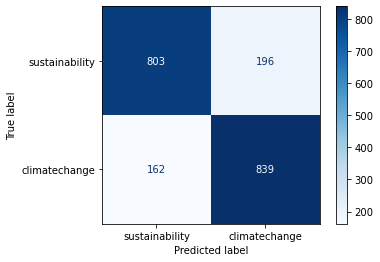

In [288]:
# I want to first take a look at my confusion matrix
plot_confusion_matrix(rs_2, X_test, y_test, display_labels=['sustainability', 'climatechange'], 
                      cmap='Blues')

In [289]:
#looking at the predictions
preds = rs_2.predict(X_test)
#identifying values of my confusion matrix 
tn, fp, fn, tp = metrics.confusion_matrix(y_test, preds).ravel()
# calculating sensitivity, specificity and overall accuracy
sensitivity_2 = tp/(tp+fn)
specificity_2 = tn/(tn+fp)
accuracy_2 = (tp+tn)/(tp+tn+fn+fp)
precision_2 = (tp)/(tp+fp)
#printing results
sensitivity_2, specificity_2, accuracy_2, precision_2

(0.8381618381618382, 0.8038038038038038, 0.821, 0.8106280193236715)

In [290]:
#calculating ROC AUC Score
probs = rs_2.predict_proba(X_test)[:,1]
metrics.roc_auc_score(y_test, probs)

0.9054659054659056

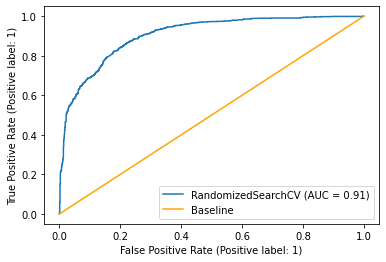

In [291]:
# Source: this graph is coming from class classsification metrics II
# I want to visualize teh false positive rate against the true positive rate
metrics.plot_roc_curve(rs_2, X_test, y_test)
plt.plot([0,1], [0,1], color ='orange', label ='Baseline')
plt.legend()

/Users/filoradice/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


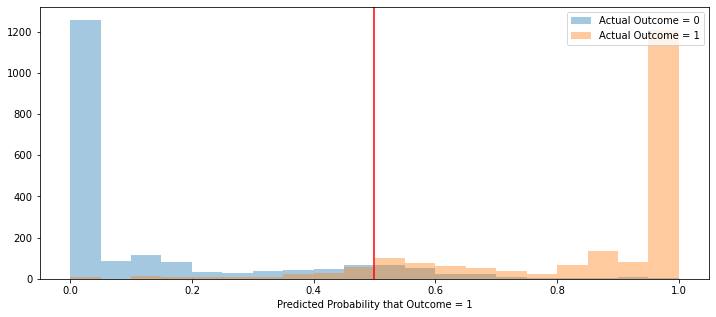

In [292]:
# Source: this graph is coming from class classification metrics II
df_probs = pd.DataFrame({'true_values': y_test, 'preds_prob':probs})
plt.figure(figsize = (12, 5))

# plot distributions of predicted probabilities by actual values
for group in df_probs.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')
# Add cutoff line
plt.axvline(.5, color='r')

plt.xlabel('Predicted Probability that Outcome = 1')
plt.legend();

**Step 5** looking at the best predictors 

In [293]:
#below I am proposing a bit more of EDA on best features predictors for both climate change and sustainability 

In [294]:
#Source of code: group effort led by Andy Orfalea
coef = rs_2.best_estimator_.named_steps['lr'].coef_ # get coefficients
features = rs_2.best_estimator_.named_steps['feats'].transformer_list[0][1].named_steps['vect'].get_feature_names() #get feature names
everything = zip(coef[0], features) #zip them together
lst = list(everything) #turn zip object into a list
predictors_sent = pd.DataFrame(lst) # turn list into a df
predictors_sent[0] = np.exp(predictors_sent[0]) # because logistic regression puts the coefficients on a log scale, you have to do this.

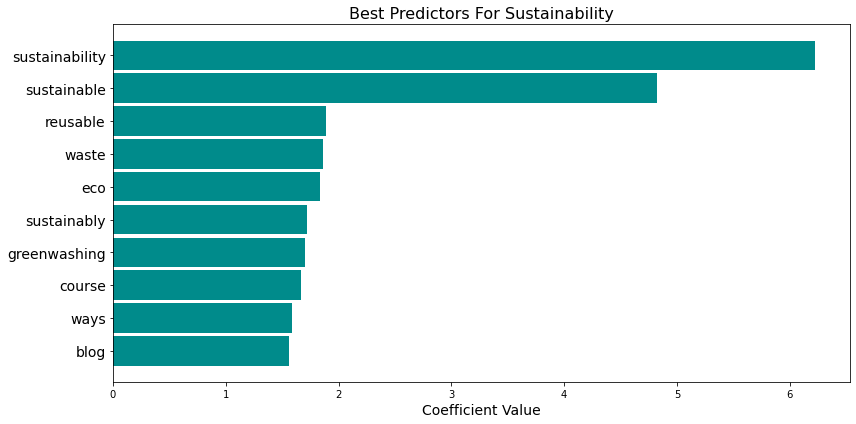

In [295]:
plt.figure(figsize=(12,6))
#best_pred_sust = predictors_sent.sort_values(by=0, ascending=False).head(10)
best_pred_sust = predictors_sent.sort_values(by=0, ascending=True).tail(10)
x = best_pred_sust[1]
y = best_pred_sust[0]
plt.barh(x,y, color ='darkcyan',  height=0.90)
plt.xlabel('Coefficient Value', fontdict= {'fontsize':14})
plt.title('Best Predictors For Sustainability', fontdict = {'fontsize':16})
ax = plt.subplot()
ax.set_yticks(x)
ax.set_yticklabels(x, fontdict= {'fontsize':14} )
plt.tight_layout();
plt.savefig(('../images/bestpredictors_sustain.png'), bbox_inches="tight", dpi=100)

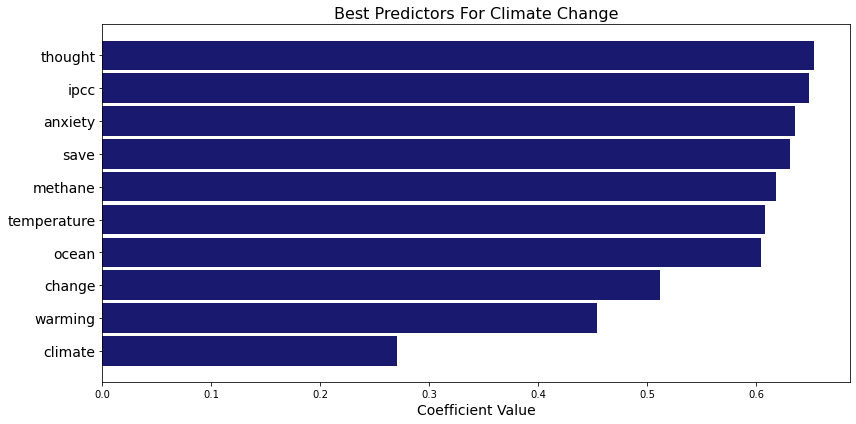

In [296]:
plt.figure(figsize=(12,6))
#best_pred_cc = predictors_sent.sort_values(by=0, ascending=False).tail(10)
best_pred_cc = predictors_sent.sort_values(by=0, ascending=True).head(10)
x = best_pred_cc[1]
y = best_pred_cc[0]
plt.barh(x,y, color ='midnightblue',  height=0.90)
plt.xlabel('Coefficient Value', fontdict= {'fontsize':14})
plt.title('Best Predictors For Climate Change', fontdict = {'fontsize':16})
ax = plt.subplot()
ax.set_yticks(x)
ax.set_yticklabels(x, fontdict= {'fontsize':14} )
plt.tight_layout();
plt.savefig(('../images/bestpredictors_climatechange.png'),  bbox_inches="tight", dpi=100)

### Conclusions

By looking at all different metrics, we can conclude that both models are making better predictions than the null model. Moreover, the sentiment analysis adds value to the prediction of the logistic model classifier. Meaning that, the difference in the sentiment score across the different subreddits improves model predictions. For instance, the best accuracy score for the model with sentiment analysis is .821 against .815 for the one without. Moreover, in part 3, we have seen how the word **anxiety** is within the 10 best  predictors for the class climate change. This seems to confirm the original hypothesis where I was expecting to detect a more positive sentiment in the sustainability group as people tend to be  more focus on the solution side of the environemntal crisis. 

Below, a summary of the different other scores computed before

Logistic Regression Scores **without** Sentiment Analysis: 
1. sensitivity 0.844 
2. specificity 0.788
3. accuracy 0.815
4. precision 0.799


Logistic Regression Scores **with** Sentiment Analysis:  
1. sensitivity 0.838 
2. specificity 0.804
3. accuracy 0.821 
4. precision 0.810



In [297]:
#accuracy score comparison between the null model, logistic regression with/without sentiment analysis

In [298]:
null_model['Logistic Regression'] = accuracy_1
null_model['Sentiment Analysis'] = accuracy_2
null_model.drop(0, inplace=True)
#check
null_model

1                      0.500438
Logistic Regression    0.815500
Sentiment Analysis     0.821000
Name: subreddit, dtype: float64

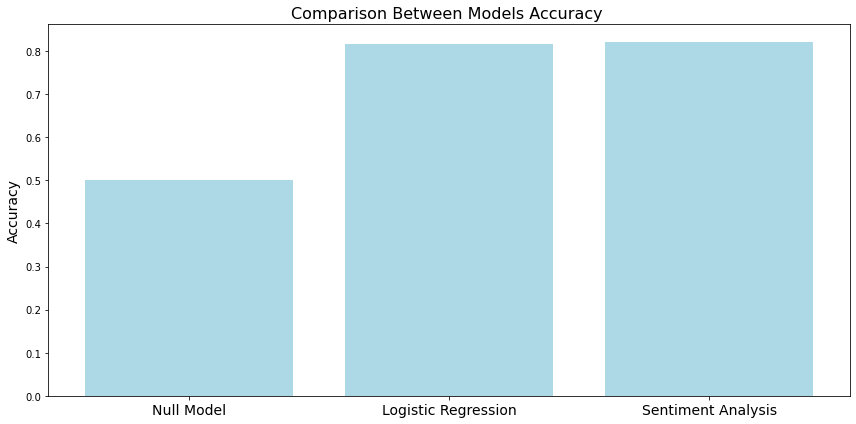

In [299]:
plt.figure(figsize=(12,6))
x = range(len(null_model.reset_index()))
y = null_model.reset_index().loc[:,'subreddit']
plt.bar(x,y, color='lightblue')
ax = plt.subplot()
ax.set_xticks(x)
ax.set_xticklabels(['Null Model', 'Logistic Regression', 'Sentiment Analysis'], fontdict= {'fontsize':14})
#ax.set_xlabel('Models', fontdict= {'fontsize':14})
ax.set_ylabel('Accuracy', fontdict= {'fontsize':14})
ax.set_title('Comparison Between Models Accuracy ', fontdict = {'fontsize':16})
plt.tight_layout();
plt.savefig(('../images/models_comparison.png'),  bbox_inches="tight", dpi=100)